<a href="https://colab.research.google.com/github/ahassanzadeh/Trending_Instagram_Posts/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Major libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import copy as cp
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Cross Validattion tools 
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
#Import Supervised Learning models 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
import xgboost as xgb

# Data Visualization 

In [ ]:
# connect to google drive and extract csv files
metrics= pd.read_csv('/content/drive/My Drive/Projects/FINESSE/post_metrics_and_comments.csv')

In [ ]:
metrics.head()

,post_url,username,date_posted,img_urls,caption,max_likes,max_comments,max_views,followers,following,concatenated_comments
0,https://www.instagram.com/p/B-y2oOeDpj2/,064_steady,2020-04-10,{https://finesse-instagram-post-images.s3-us-w...,온라인개학으로 아침마다 아이들에게 모닝콜을 해줄 수 있어서 행복합니다. 하하하하😭 ...,1019,38,NaN,8423,697,@_o9.02 가입하자 연재야😘|아고 ㅠㅠㅠㅠ 힘드실텐데 아자아자 화이팅입니다 !!...
1,https://www.instagram.com/p/B_B4e5qDtOU/,064_steady,2020-04-16,{https://finesse-instagram-post-images.s3-us-w...,2014. 04. 16. 우리 모두 웃을 수 있기를... more,1039,12,NaN,8423,697,@nam_bbs 정말요?🙌|옷입는 스타일 너무너무 멋있으세요 ☺️|코디 너무 좋아요...
2,https://www.instagram.com/p/B-3-Skoj2ub/,064_steady,2020-04-12,{https://finesse-instagram-post-images.s3-us-w...,내일이 월요일이니까 웃자😁... more,764,35,NaN,8423,697,❤️|헐 선생님....멋져요....♥️|워료일 쪼아~ 최고로 쪼아~|Very sum...
3,https://www.instagram.com/p/B_UhfCuDnJU/,064_steady,2020-04-23,{https://finesse-instagram-post-images.s3-us-w...,너무 배불러요 ㅠㅠㅠ... more,779,56,NaN,8423,697,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭👍🏿|😍😍😍😍❤...
4,https://www.instagram.com/p/B-6isIeD-0-/,064_steady,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,월요병 극복🥴,733,26,NaN,8423,697,극복 나이스👍🏻|@mndp404 시간은 결국 흐르니 ㅠㅠ|내일도 화요팅~!|@yeo...


In [ ]:
# make a copy of original drive for modifications
new_metrics = cp.deepcopy(metrics)
# remove Null values
new_metrics.dropna(axis= 1, inplace= True)
new_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11637 entries, 0 to 11636
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   post_url               11637 non-null  object
 1   username               11637 non-null  object
 2   date_posted            11637 non-null  object
 3   img_urls               11637 non-null  object
 4   max_likes              11637 non-null  int64 
 5   max_comments           11637 non-null  int64 
 6   followers              11637 non-null  int64 
 7   following              11637 non-null  int64 
 8   concatenated_comments  11637 non-null  object
dtypes: int64(4), object(5)
memory usage: 818.4+ KB


Since we have the maximum number of likes for each post(max_likes), the main criteria for trending post can be ** the number of likes divided by mean(average) of likes for each username assigned to all the post_url**. it also can simply called **weighted_mean_likes**. Therefore we use feature engineering to extract features that help our regression model to predict the **weighted_mean_likes** more accuretely. 

# Feature Engineering 
## Median, means and weighted mean of likes and comments
Adding mean of likes/comments and weighted mean of likes/comments as 4 new features

In [ ]:

def weighted_mean_columns(dataframe, col, new_col):
  mean = dataframe.groupby('username')[col].mean()

  # def weighted_average(matrix, col_name)
  hash ={}
  for idx in range(len(mean)):
    hash[mean.index[idx]] = mean[idx]

  dataframe[new_col] = None
  for idx in range(len(dataframe)):
    username = dataframe.username[idx]
    dataframe[new_col][idx] = round(dataframe[col][idx].astype(float) / hash[username] , 6 )

def mean(dataframe, col, new_col):
  mean = dataframe.groupby('username')[col].mean()
  hash = {}
  for idx in range(len(mean)):
    hash[mean.index[idx]] = mean[idx]
  dataframe[new_col] = None
  for idx in range(len(dataframe)):
    username = dataframe.username[idx]
    dataframe[new_col][idx] = round(hash[username] , 6)

def median(dataframe, col, new_col):
  median = dataframe.groupby('username')[col].median()
  hash = {}
  for idx in range(len(median)):
    hash[median.index[idx]] = median[idx]
  
  dataframe[new_col] = None
  for idx in range(len(dataframe)):
    username = dataframe.username[idx]
    dataframe[new_col][idx] = round(hash[username] , 6)


# running functions
weighted_mean_columns(new_metrics, 'max_likes', 'weighted_mean_likes')
weighted_mean_columns(new_metrics, 'max_comments', 'weighted_mean_comments')
mean(new_metrics, 'max_likes', 'mean_likes')
mean(new_metrics, 'max_comments', 'mean_comments')
median(new_metrics, 'max_likes', 'median_likes')


# changing the data type from object to float 
new_metrics['weighted_mean_likes'] = new_metrics['weighted_mean_likes'].astype(float)
new_metrics['weighted_mean_comments'] = new_metrics['weighted_mean_comments'].astype(float)
new_metrics['mean_likes'] = new_metrics['mean_likes'].astype(float)
new_metrics['mean_comments'] = new_metrics['mean_comments'].astype(float)
new_metrics['median_likes'] = new_metrics['median_likes'].astype(float)

new_metrics.head()

,post_url,username,date_posted,img_urls,max_likes,max_comments,followers,following,concatenated_comments,weighted_mean_likes,weighted_mean_comments,mean_likes,mean_comments,median_likes
0,https://www.instagram.com/p/B-y2oOeDpj2/,064_steady,2020-04-10,{https://finesse-instagram-post-images.s3-us-w...,1019,38,8423,697,@_o9.02 가입하자 연재야😘|아고 ㅠㅠㅠㅠ 힘드실텐데 아자아자 화이팅입니다 !!...,1.111434,1.024719,916.833333,37.083333,891.5
1,https://www.instagram.com/p/B_B4e5qDtOU/,064_steady,2020-04-16,{https://finesse-instagram-post-images.s3-us-w...,1039,12,8423,697,@nam_bbs 정말요?🙌|옷입는 스타일 너무너무 멋있으세요 ☺️|코디 너무 좋아요...,1.133249,0.323596,916.833333,37.083333,891.5
2,https://www.instagram.com/p/B-3-Skoj2ub/,064_steady,2020-04-12,{https://finesse-instagram-post-images.s3-us-w...,764,35,8423,697,❤️|헐 선생님....멋져요....♥️|워료일 쪼아~ 최고로 쪼아~|Very sum...,0.833303,0.943820,916.833333,37.083333,891.5
3,https://www.instagram.com/p/B_UhfCuDnJU/,064_steady,2020-04-23,{https://finesse-instagram-post-images.s3-us-w...,779,56,8423,697,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭👍🏿|😍😍😍😍❤...,0.849664,1.510112,916.833333,37.083333,891.5
4,https://www.instagram.com/p/B-6isIeD-0-/,064_steady,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,733,26,8423,697,극복 나이스👍🏻|@mndp404 시간은 결국 흐르니 ㅠㅠ|내일도 화요팅~!|@yeo...,0.799491,0.701124,916.833333,37.083333,891.5


In [ ]:
# remove all the null values
new_metrics.dropna(axis=0, inplace=True)
new_metrics.isnull().sum()

post_url                  0
username                  0
date_posted               0
img_urls                  0
max_likes                 0
max_comments              0
followers                 0
following                 0
concatenated_comments     0
weighted_mean_likes       0
weighted_mean_comments    0
mean_likes                0
mean_comments             0
median_likes              0
dtype: int64

## Adding days of week(Monday, Tuesday, ...)

In [ ]:
#find the start and end date of data
print(new_metrics['date_posted'].min())
print(new_metrics['date_posted'].max())

2020-04-01
2020-04-26


In [ ]:
# Adding days as a features
new_metrics['Monday'] = 0 
new_metrics['Tuesday'] = 0 
new_metrics['Wednesday'] = 0 
new_metrics['Thursday'] = 0 
new_metrics['Friday'] = 0 
new_metrics['Saturday'] = 0 
new_metrics['Sunday'] = 0 

for i, dates in enumerate(new_metrics['date_posted']):
  if i == 0:
    start_day = datetime(2020,4,1)
  date_time = datetime.strptime(dates, f'%Y-%m-%d')
  n = (date_time - start_day).days %7
  if n==0:
    new_metrics['Wednesday'][i] = 1
  elif n==1:
    new_metrics['Thursday'][i] = 1
  elif n==2:
    new_metrics['Friday'][i] = 1
  elif n==3:
    new_metrics['Saturday'][i] = 1
  elif n==4:
    new_metrics['Sunday'][i] = 1
  elif n==5:
    new_metrics['Monday'][i] = 1
  elif n==6:
    new_metrics['Tuesday'][i] =1

new_metrics.head()

,post_url,username,date_posted,img_urls,max_likes,max_comments,followers,following,concatenated_comments,weighted_mean_likes,weighted_mean_comments,mean_likes,mean_comments,median_likes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,https://www.instagram.com/p/B-y2oOeDpj2/,064_steady,2020-04-10,{https://finesse-instagram-post-images.s3-us-w...,1019,38,8423,697,@_o9.02 가입하자 연재야😘|아고 ㅠㅠㅠㅠ 힘드실텐데 아자아자 화이팅입니다 !!...,1.111434,1.024719,916.833333,37.083333,891.5,0,0,0,0,1,0,0
1,https://www.instagram.com/p/B_B4e5qDtOU/,064_steady,2020-04-16,{https://finesse-instagram-post-images.s3-us-w...,1039,12,8423,697,@nam_bbs 정말요?🙌|옷입는 스타일 너무너무 멋있으세요 ☺️|코디 너무 좋아요...,1.133249,0.323596,916.833333,37.083333,891.5,0,0,0,1,0,0,0
2,https://www.instagram.com/p/B-3-Skoj2ub/,064_steady,2020-04-12,{https://finesse-instagram-post-images.s3-us-w...,764,35,8423,697,❤️|헐 선생님....멋져요....♥️|워료일 쪼아~ 최고로 쪼아~|Very sum...,0.833303,0.943820,916.833333,37.083333,891.5,0,0,0,0,0,0,1
3,https://www.instagram.com/p/B_UhfCuDnJU/,064_steady,2020-04-23,{https://finesse-instagram-post-images.s3-us-w...,779,56,8423,697,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭👍🏿|😍😍😍😍❤...,0.849664,1.510112,916.833333,37.083333,891.5,0,0,0,1,0,0,0
4,https://www.instagram.com/p/B-6isIeD-0-/,064_steady,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,733,26,8423,697,극복 나이스👍🏻|@mndp404 시간은 결국 흐르니 ㅠㅠ|내일도 화요팅~!|@yeo...,0.799491,0.701124,916.833333,37.083333,891.5,1,0,0,0,0,0,0


## Adding days that days that post was in top trending hashtags:  

In [ ]:
hashtags = pd.read_csv('/content/drive/My Drive/Projects/FINESSE/hashtag_top_appearances.csv')
hashtags.head()
hashtags['post_url'] = hashtags['post_url'].astype(str)
hashtags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25062 entries, 0 to 25061
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   post_url                     25062 non-null  object
 1   days_in_hashtag_top_section  25062 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 391.7+ KB


In [ ]:
new_metrics['days_in_hashtag_top_section'] = 0 
for idx, hashtag1 in enumerate(new_metrics['post_url']):
  for idx2, hashtag2 in enumerate(hashtags['post_url']):
    if hashtag2 == hashtag1:
      new_metrics['days_in_hashtag_top_section'][idx] = hashtags['days_in_hashtag_top_section'][idx2]
      break
    
new_metrics.head()

,post_url,username,date_posted,img_urls,max_likes,max_comments,followers,following,concatenated_comments,weighted_mean_likes,weighted_mean_comments,mean_likes,mean_comments,median_likes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,days_in_hashtag_top_section
0,https://www.instagram.com/p/B-y2oOeDpj2/,064_steady,2020-04-10,{https://finesse-instagram-post-images.s3-us-w...,1019,38,8423,697,@_o9.02 가입하자 연재야😘|아고 ㅠㅠㅠㅠ 힘드실텐데 아자아자 화이팅입니다 !!...,1.111434,1.024719,916.833333,37.083333,891.5,0,0,0,0,1,0,0,0
1,https://www.instagram.com/p/B_B4e5qDtOU/,064_steady,2020-04-16,{https://finesse-instagram-post-images.s3-us-w...,1039,12,8423,697,@nam_bbs 정말요?🙌|옷입는 스타일 너무너무 멋있으세요 ☺️|코디 너무 좋아요...,1.133249,0.323596,916.833333,37.083333,891.5,0,0,0,1,0,0,0,0
2,https://www.instagram.com/p/B-3-Skoj2ub/,064_steady,2020-04-12,{https://finesse-instagram-post-images.s3-us-w...,764,35,8423,697,❤️|헐 선생님....멋져요....♥️|워료일 쪼아~ 최고로 쪼아~|Very sum...,0.833303,0.943820,916.833333,37.083333,891.5,0,0,0,0,0,0,1,0
3,https://www.instagram.com/p/B_UhfCuDnJU/,064_steady,2020-04-23,{https://finesse-instagram-post-images.s3-us-w...,779,56,8423,697,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭👍🏿|😍😍😍😍❤...,0.849664,1.510112,916.833333,37.083333,891.5,0,0,0,1,0,0,0,0
4,https://www.instagram.com/p/B-6isIeD-0-/,064_steady,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,733,26,8423,697,극복 나이스👍🏻|@mndp404 시간은 결국 흐르니 ㅠㅠ|내일도 화요팅~!|@yeo...,0.799491,0.701124,916.833333,37.083333,891.5,1,0,0,0,0,0,0,0


# Adding number of posts for each username 

In [ ]:
new_metrics['number_of_posts'] = 0
dummy = new_metrics.groupby('username')['post_url'].count()
for idx, line in enumerate(new_metrics['username']):
  new_metrics['number_of_posts'][idx] = dummy[line]
new_metrics.head()

,post_url,username,date_posted,img_urls,max_likes,max_comments,followers,following,concatenated_comments,weighted_mean_likes,weighted_mean_comments,mean_likes,mean_comments,median_likes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,days_in_hashtag_top_section,number_of_posts
0,https://www.instagram.com/p/B-y2oOeDpj2/,064_steady,2020-04-10,{https://finesse-instagram-post-images.s3-us-w...,1019,38,8423,697,@_o9.02 가입하자 연재야😘|아고 ㅠㅠㅠㅠ 힘드실텐데 아자아자 화이팅입니다 !!...,1.111434,1.024719,916.833333,37.083333,891.5,0,0,0,0,1,0,0,0,12
1,https://www.instagram.com/p/B_B4e5qDtOU/,064_steady,2020-04-16,{https://finesse-instagram-post-images.s3-us-w...,1039,12,8423,697,@nam_bbs 정말요?🙌|옷입는 스타일 너무너무 멋있으세요 ☺️|코디 너무 좋아요...,1.133249,0.323596,916.833333,37.083333,891.5,0,0,0,1,0,0,0,0,12
2,https://www.instagram.com/p/B-3-Skoj2ub/,064_steady,2020-04-12,{https://finesse-instagram-post-images.s3-us-w...,764,35,8423,697,❤️|헐 선생님....멋져요....♥️|워료일 쪼아~ 최고로 쪼아~|Very sum...,0.833303,0.943820,916.833333,37.083333,891.5,0,0,0,0,0,0,1,0,12
3,https://www.instagram.com/p/B_UhfCuDnJU/,064_steady,2020-04-23,{https://finesse-instagram-post-images.s3-us-w...,779,56,8423,697,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭👍🏿|😍😍😍😍❤...,0.849664,1.510112,916.833333,37.083333,891.5,0,0,0,1,0,0,0,0,12
4,https://www.instagram.com/p/B-6isIeD-0-/,064_steady,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,733,26,8423,697,극복 나이스👍🏻|@mndp404 시간은 결국 흐르니 ㅠㅠ|내일도 화요팅~!|@yeo...,0.799491,0.701124,916.833333,37.083333,891.5,1,0,0,0,0,0,0,0,12


# Correlation Analysis

Find the correlation of other parameters to 

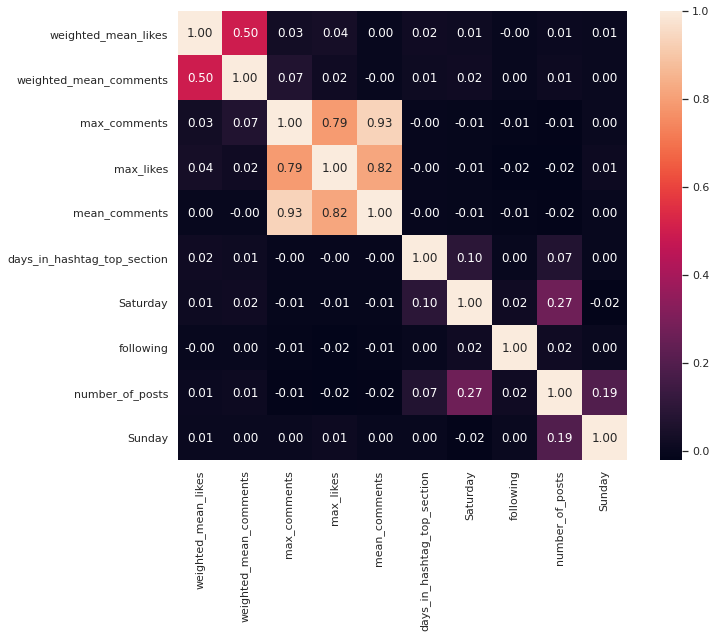

In [ ]:
correlation = new_metrics.corr(method='spearman')
columns = correlation.nlargest(10, 'weighted_mean_likes').index
correlation_map = np.corrcoef(new_metrics[columns].values.T)
sns.set(font_scale=0.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.show()

 # The most significant correlations are listed below:

In [ ]:
correlations=new_metrics.corr()
attrs = correlations.iloc[:-1,:-1] # all except target

threshold = 0.5
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]).unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

    # sorted by absolute value
unique_important_corrs = unique_important_corrs.loc[
    abs(unique_important_corrs['Correlation']).argsort()[::-1]]

unique_important_corrs

,Attribute Pair,Correlation
1,"(mean_likes, median_likes)",0.998792
6,"(max_likes, mean_likes)",0.958116
12,"(max_likes, median_likes)",0.956959
14,"(max_comments, mean_comments)",0.934610
7,"(mean_comments, median_likes)",0.862048
9,"(mean_comments, mean_likes)",0.854096
0,"(max_likes, mean_comments)",0.818323
13,"(max_comments, median_likes)",0.805678
5,"(followers, mean_likes)",0.804404
8,"(max_comments, mean_likes)",0.798246


In [ ]:
new_metrics[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday','weighted_mean_likes']].groupby(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
as_index=False).mean().sort_values(by='Sunday', ascending=False)

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weighted_mean_likes
1,0,0,0,0,0,0,1,1.018463
0,0,0,0,0,0,0,0,0.996153
2,0,0,0,0,0,1,0,1.063322
3,0,0,0,0,1,0,0,1.021384
4,0,0,0,1,0,0,0,0.986748
5,0,0,1,0,0,0,0,1.019552
6,0,1,0,0,0,0,0,0.975297
7,1,0,0,0,0,0,0,1.026244


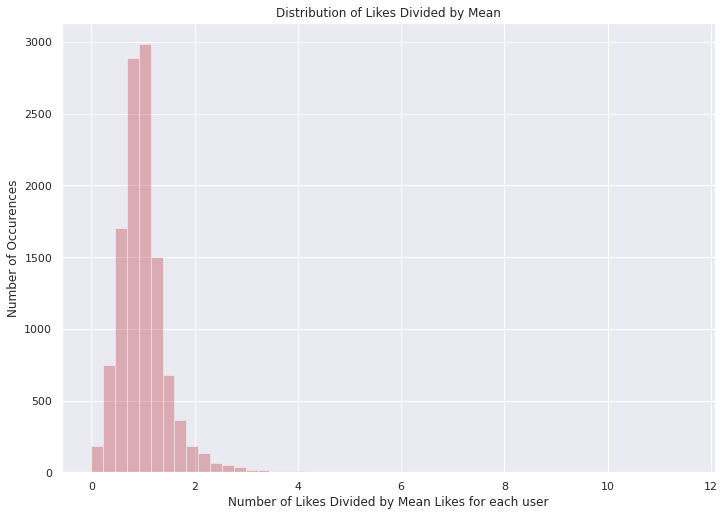

In [ ]:
sns.distplot(new_metrics['weighted_mean_likes'], color="r", kde=False)
plt.title("Distribution of Likes Divided by Mean")
plt.ylabel("Number of Occurences")
plt.xlabel("Number of Likes Divided by Mean Likes for each user");

Return unbiased skew over requested axis.



$

In [ ]:
# Measuring the skewness of the weighted_mean_likes column which 
# Skewness is the indication of symmetry in the distribution and the equatuin is E((X-mean)/(standard_deviation)**3)
new_metrics['weighted_mean_likes'].skew()

3.5473315849085787

In [ ]:
# measuring the Kurtosis of the weighted_mean_likes column.
# Kurtosis measure the strength of long tail in the distribution and the equation is  E((X-mean)/(standard_deviation)**4)
new_metrics['weighted_mean_likes'].kurt()

36.713053369616595

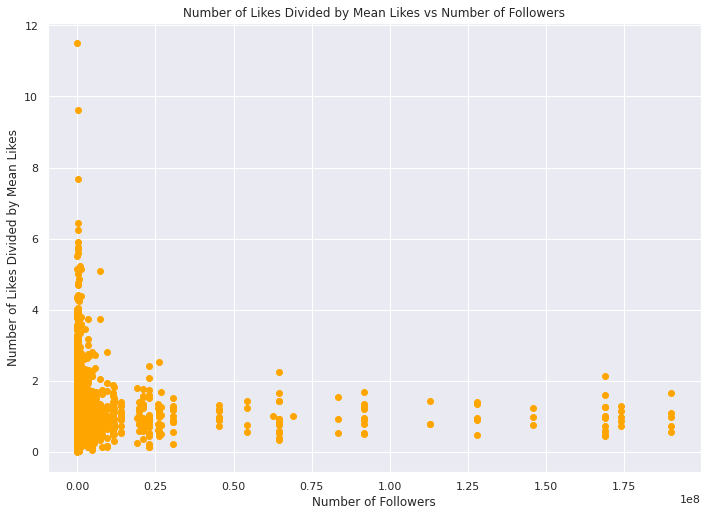

In [ ]:
plt.scatter(new_metrics['followers'], new_metrics["weighted_mean_likes"], color='orange')
plt.title("Number of Likes Divided by Mean Likes vs Number of Followers")
plt.xlabel("Number of Followers")
plt.ylabel("Number of Likes Divided by Mean Likes");

# Training and Predictions with the model 

In [ ]:
new_metrics.drop(['post_url','username', 'date_posted', 'img_urls', 'concatenated_comments'], axis=1, inplace= True)
new_metrics.sort_values(by = 'weighted_mean_likes', ascending = True, inplace= True)
new_metrics.tail()

,max_likes,max_comments,followers,following,weighted_mean_likes,weighted_mean_comments,mean_likes,mean_comments,median_likes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,days_in_hashtag_top_section,number_of_posts
1706,28732,92,47800,1,6.253734,2.016438,4594.375000,45.625000,3141.5,0,0,0,1,0,0,0,0,0
3868,30487,135,63600,15,6.448727,3.103448,4727.600000,43.500000,3338.5,0,0,0,1,0,0,0,0,0
2911,32346,498,96200,117,7.675192,5.528945,4214.357143,90.071429,1401.0,1,0,0,0,0,0,0,0,0
3120,54413,283,112000,1114,9.623617,3.265385,5654.111111,86.666667,2920.0,1,0,0,0,0,0,0,0,0
3406,3083,73,1649,1342,11.498964,2.246154,268.111111,32.500000,70.5,0,0,0,0,0,0,0,0,0


In [ ]:
new_metrics_original = cp.deepcopy(new_metrics)
X, y = new_metrics.drop('weighted_mean_likes',axis=1), new_metrics.weighted_mean_likes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
# X.info()

In [ ]:
models = []
models.append(('GBM',GradientBoostingRegressor()))
models.append(('LR',LinearRegression()))
models.append(('BYR', BayesianRidge()))
models.append(("KNN", KNeighborsRegressor()))
models.append(('XGB', xgb.XGBRegressor()))


In [ ]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "r2")
    print(name, cv_result)

GBM [0.79100662 0.80876924]
LR [0.24534761 0.27155094]
BYR [0.24580863 0.27400119]
KNN [0.47374952 0.54218482]
[18:50:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:50:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB [0.78442338 0.81472936]


In [ ]:
X, y = new_metrics_original.drop('weighted_mean_likes', axis=1), new_metrics_original.weighted_mean_likes
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, shuffle = False)
model = xgb.XGBRegressor()
model.fit(X_train,y_train)
predictions = model.predict(X_test2)
y_train.head()
compare = pd.DataFrame({'Prediction': predictions, 'Ground Truth' : y_test2})
print(compare.tail(10))
pred= sorted(predictions, reverse= True)
print(pred[:10])


[19:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
       Prediction  Ground Truth
4048     5.976807      5.518340
10091    3.592964      5.602607
10917    5.343872      5.697391
3451     4.395563      5.768078
5364     5.564166      5.918774
1706     5.726154      6.253734
3868     5.595409      6.448727
2911     6.724216      7.675192
3120     7.076157      9.623617
3406     9.577948     11.498964
[9.577948, 7.076157, 6.7242155, 5.9768066, 5.7261543, 5.595409, 5.5641656, 5.343872, 4.4611506, 4.452263]


Top 5 predicted post are as follows:



In [ ]:
metrics.loc[[3406, 3120, 2911, 4048, 1706], 'post_url']

3406    https://www.instagram.com/p/B_NkieupTpm/
3120    https://www.instagram.com/p/B_SkEZOB50m/
2911    https://www.instagram.com/p/B_DUCGpJvA8/
4048    https://www.instagram.com/p/B-2Uhffhixi/
1706    https://www.instagram.com/p/B_FGAgSpf8j/
Name: post_url, dtype: object

# Further Improvement

As it is shown in the previous section, the current model can predict the weighted mean(average) of likes for the top trending post with 80% accuracy. For even further improvements,  it is possible to extract more features from images, comments and captions and use ensemble models to increase the prediction accuracy. 

## Image features and model :

They are multiple features can be extracted from the imgeas/videos:

1- Number of Indivisuals 
<br>
2- Facial Expression (smile, wink, ...) 
<br>
3- Animal detections(birds, cat, dog ..) 
<br>

For the Image recognition model, as this a computer vision task, OpenCV library can generate the best model using many implemented tools for feature extraction and facial recognition classification.

## Text(captions/comments) features and model : 

First thing for the text is to make sure, all the comments/captions are translated to unique language(English) using Google translate free API. 
After that, multiple features can be extracted from the comments and captions:

1- locations 
<br>
2- hashtags 
<br>
3- biography 
<br>
4- suprising moment(Marriage proposal,..)
<br>
5- shocking indcients(Death, Accident, ..)
<br>

For this model, as this a natural language processing(NLP) task, we can use TextBlob for sentiment analysis which  the overal score of comments and captions can be calculated using positive (+1 score), negative (-1 score) and neutral(0 score) for each comments/captions. 
